In [1]:
import sys

sys.path.append('/Users/tristenmarto/Documents/Studie/Thesis/Synthsonic_data_analysis')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

from collections import Counter

import xgboost as xgb

from imblearn.datasets import fetch_datasets

from Evaluation import synthsonic

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import smote_variants as sv

In [3]:
# metrics 
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import (recall_score, roc_auc_score, confusion_matrix, precision_score, precision_recall_curve,
                             f1_score, balanced_accuracy_score, accuracy_score, average_precision_score)

In [4]:
_logger = logging.getLogger('smote_variants')
_logger.setLevel(logging.DEBUG)
_logger_ch = logging.StreamHandler()
_logger_ch.setFormatter(logging.Formatter(
    "%(asctime)s:%(levelname)s:%(message)s"))
_logger.addHandler(_logger_ch)

In [5]:
random_state = 5

# data checks

In [6]:
# loading imblearn dataset

data = fetch_datasets()['yeast_ml8']

X,y, name = data['data'], data['target'], data['DESCR']

In [7]:
def pca_plot(X,y) :
    
    x = StandardScaler().fit_transform(X)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    
    fig = plt.figure(figsize = (12,7))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(f'2 component PCA')

    counter = Counter(y)

    for label, _ in counter.items() :
        rowix = np.where(y == label)[0]
        ax.scatter(principalComponents[rowix, 0], principalComponents[rowix, 1], label=str(label))

    ax.legend()

    fig.show()
    print(counter)

Counter({-1: 2239, 1: 178})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


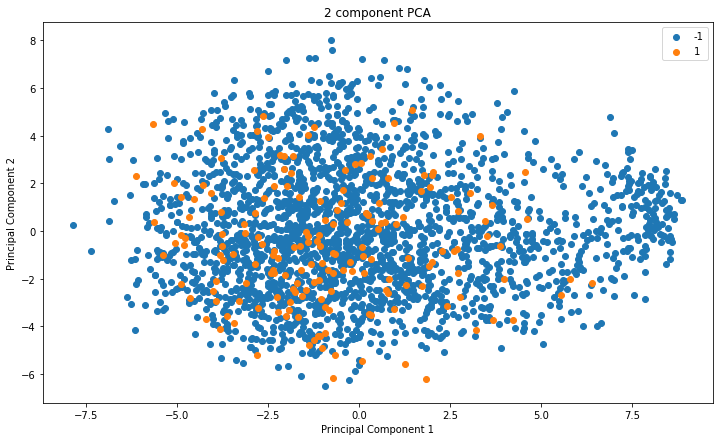

In [8]:
pca_plot(X,y)

In [9]:
for i in range(X.shape[1]) :
    print(i, len(np.unique(X[:,i])))

0 2412
1 2406
2 2413
3 2407
4 2408
5 2407
6 2409
7 2405
8 2406
9 2415
10 2414
11 2406
12 2407
13 2406
14 2403
15 2409
16 2410
17 2409
18 2410
19 2409
20 2406
21 2409
22 2410
23 2406
24 2403
25 2411
26 2411
27 2410
28 2413
29 2408
30 2406
31 2412
32 2407
33 2407
34 2408
35 2410
36 2412
37 2404
38 2411
39 2407
40 2404
41 2404
42 2407
43 2404
44 2409
45 2414
46 2407
47 2406
48 2407
49 2411
50 2409
51 2408
52 2408
53 2409
54 2407
55 2406
56 2413
57 2411
58 2414
59 2405
60 2410
61 2405
62 2407
63 2401
64 2410
65 2411
66 2407
67 2405
68 2409
69 2412
70 2409
71 2408
72 2409
73 2412
74 2410
75 2407
76 2410
77 2408
78 2409
79 2407
80 2404
81 2408
82 2405
83 2400
84 2401
85 2393
86 2401
87 2401
88 2403
89 2408
90 2406
91 2403
92 2403
93 2410
94 2403
95 2401
96 2404
97 2404
98 2400
99 2401
100 2405
101 2408
102 2405


# Evaluation - base scenario

In [10]:
def test_metrics(training, testing, y_training, y_testing, clf, title) :
    
    clf.fit(training,y_training)
    prediction = clf.predict(testing)
    proba = clf.predict_proba(testing)[:,1]

    f_dict = {
        'title': title,
        'balanced acc': balanced_accuracy_score(y_testing,prediction),
        'precision': precision_score(y_testing,prediction),
        'recall': recall_score(y_testing,prediction),
        'f1_score': f1_score(y_testing, prediction, average='binary'),
        'geometric mean': geometric_mean_score(y_testing, prediction),
        'average precision': average_precision_score(y_testing, prediction)
    }

    return f_dict

In [11]:
# base case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = random_state)

In [12]:
X_train.shape, X_test.shape

((1450, 103), (967, 103))

In [13]:
clf = xgb.XGBClassifier(verbosity = 0, random_state=random_state)

cv_result = cross_validate(clf, X_train, y_train, scoring=[
                                                           "balanced_accuracy",
                                                           "precision",
                                                           "recall",
                                                           "roc_auc_ovr_weighted",
                                                           "f1",
                                                           "average_precision"
                                                           ])

/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the 

In [14]:
for key, data in cv_result.items() :
    print(key, data.mean())

fit_time 0.25692195892333985
score_time 0.006843996047973633
test_balanced_accuracy 0.5047619047619047
test_precision 0.2
test_recall 0.009523809523809523
test_roc_auc_ovr_weighted 0.5726677288015578
test_f1 0.01818181818181818
test_average_precision 0.12111027838031499


In [15]:
res_standard = test_metrics(X_train,X_test,y_train,y_test, clf, "XGBoost: No SMOTE")
res_standard

/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'title': 'XGBoost: No SMOTE',
 'balanced acc': 0.5,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'geometric mean': 0.0,
 'average precision': 0.07549120992761117}

In [16]:
clf.fit(X_train,y_train)

prediction = clf.predict(X_test)

confusion_matrix(y_test,prediction)

array([[894,   0],
       [ 73,   0]])

In [17]:
results = pd.DataFrame(res_standard, index=[0])
results

,title,balanced acc,precision,recall,f1_score,geometric mean,average precision
0,XGBoost: No SMOTE,0.5,0.0,0.0,0.0,0.0,0.075491


# Sample generation

In [18]:
proportions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [19]:
samples_smote = []

for prop in proportions :
    o = sv.SMOTE(proportion = prop,
                   random_state = random_state)
    
    print(prop)
    x_g, y_g = o.sample(X_train,y_train)
    
    f_dict = {
        'prop':prop,
        'x_sample':x_g,
        'y_sample':y_g
    }
    
    samples_smote.append(f_dict)

2021-06-14 11:06:28,187:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-14 11:06:28,187:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-14 11:06:28,187:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-14 11:06:28,194:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-14 11:06:28,194:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-14 11:06:28,194:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-14 11:06:28,201:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-14 11:06:28,

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1


In [20]:
samples_synth = []

for prop in proportions :
    o = synthsonic(distinct_threshold=-1,
                   proportion = prop,
                   random_state = random_state)
    
    print(prop)
    x_g, y_g = o.sample(X_train,y_train)
    
    f_dict = {
        'prop':prop,
        'x_sample':x_g,
        'y_sample':y_g
    }
    
    samples_synth.append(f_dict)

2021-06-14 11:06:43,559:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.1, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE11B5E5E20}")
2021-06-14 11:06:43,559:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.1, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE11B5E5E20}")
2021-06-14 11:06:43,559:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.1, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE11B5E5E20}")
n_quantiles (500) is greater than the total number of samples (105). n_quantiles is set to num samples.


0.1
minority class 1, min dataset (105, 103)


Building tree: 100%|██████████| 5151/5151.0 [00:05<00:00, 910.94it/s]
Generating for node: 83: 100%|██████████| 103/103 [00:07<00:00, 14.18it/s]
2021-06-14 11:08:09,601:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10A8035A0}")
2021-06-14 11:08:09,601:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10A8035A0}")
2021-06-14 11:08:09,601:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10A8035A0}")
n_quantiles (500) is greater than the total number of samples (105). n_quantiles is set to num samples.


0.2
minority class 1, min dataset (105, 103)


Building tree: 100%|██████████| 5151/5151.0 [00:05<00:00, 979.17it/s] 
Generating for node: 83: 100%|██████████| 103/103 [00:07<00:00, 13.79it/s]
2021-06-14 11:09:34,231:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.3, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10D9BAAF0}")
2021-06-14 11:09:34,231:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.3, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10D9BAAF0}")
2021-06-14 11:09:34,231:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.3, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10D9BAAF0}")
n_quantiles (500) is greater than the total number of samples (105). n_quantiles is set to num samples.


0.3
minority class 1, min dataset (105, 103)


Building tree: 100%|██████████| 5151/5151.0 [00:05<00:00, 999.18it/s] 
Generating for node: 83: 100%|██████████| 103/103 [00:07<00:00, 14.05it/s]
2021-06-14 11:10:57,263:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10AED2160}")
2021-06-14 11:10:57,263:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10AED2160}")
2021-06-14 11:10:57,263:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10AED2160}")
n_quantiles (500) is greater than the total number of samples (105). n_quantiles is set to num samples.


0.4
minority class 1, min dataset (105, 103)


Building tree: 100%|██████████| 5151/5151.0 [00:05<00:00, 887.37it/s] 
Generating for node: 83: 100%|██████████| 103/103 [00:07<00:00, 13.76it/s]
2021-06-14 11:12:23,209:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.5, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10C8D76B0}")
2021-06-14 11:12:23,209:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.5, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10C8D76B0}")
2021-06-14 11:12:23,209:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.5, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10C8D76B0}")
n_quantiles (500) is greater than the total number of samples (105). n_quantiles is set to num samples.


0.5
minority class 1, min dataset (105, 103)


Building tree: 100%|██████████| 5151/5151.0 [00:05<00:00, 905.17it/s] 
Generating for node: 83: 100%|██████████| 103/103 [00:07<00:00, 13.54it/s]
2021-06-14 11:13:54,487:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10B24FC00}")
2021-06-14 11:13:54,487:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10B24FC00}")
2021-06-14 11:13:54,487:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE10B24FC00}")
n_quantiles (500) is greater than the total number of samples (105). n_quantiles is set to num samples.


0.6
minority class 1, min dataset (105, 103)


Building tree: 100%|██████████| 5151/5151.0 [00:05<00:00, 955.96it/s] 
Generating for node: 83: 100%|██████████| 103/103 [00:07<00:00, 13.68it/s]
2021-06-14 11:15:19,399:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.7, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE0B02D0270}")
2021-06-14 11:15:19,399:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.7, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE0B02D0270}")
2021-06-14 11:15:19,399:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.7, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE0B02D0270}")
n_quantiles (500) is greater than the total number of samples (105). n_quantiles is set to num samples.


0.7
minority class 1, min dataset (105, 103)


Building tree: 100%|██████████| 5151/5151.0 [00:05<00:00, 976.23it/s] 
Generating for node: 83: 100%|██████████| 103/103 [00:07<00:00, 13.61it/s]
2021-06-14 11:16:43,772:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE0B0DF97C0}")
2021-06-14 11:16:43,772:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE0B0DF97C0}")
2021-06-14 11:16:43,772:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE0B0DF97C0}")
n_quantiles (500) is greater than the total number of samples (105). n_quantiles is set to num samples.


0.8
minority class 1, min dataset (105, 103)


Building tree: 100%|██████████| 5151/5151.0 [00:06<00:00, 779.89it/s]
Generating for node: 83: 100%|██████████| 103/103 [00:07<00:00, 13.33it/s]
2021-06-14 11:18:14,991:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.9, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE09F29BD10}")
2021-06-14 11:18:14,991:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.9, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE09F29BD10}")
2021-06-14 11:18:14,991:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.9, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE09F29BD10}")
n_quantiles (500) is greater than the total number of samples (105). n_quantiles is set to num samples.


0.9
minority class 1, min dataset (105, 103)


Building tree: 100%|██████████| 5151/5151.0 [00:05<00:00, 944.57it/s] 
Generating for node: 83: 100%|██████████| 103/103 [00:07<00:00, 13.55it/s]
2021-06-14 11:19:40,153:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE0B0DF96B0}")
2021-06-14 11:19:40,153:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE0B0DF96B0}")
2021-06-14 11:19:40,153:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7FE0B0DF96B0}")
n_quantiles (500) is greater than the total number of samples (105). n_quantiles is set to num samples.


1
minority class 1, min dataset (105, 103)


Building tree: 100%|██████████| 5151/5151.0 [00:05<00:00, 948.58it/s]
Generating for node: 83: 100%|██████████| 103/103 [00:07<00:00, 13.88it/s]


In [21]:
xs_smote = [samples_smote[i]['x_sample'] for i in range(len(proportions))]
ys_smote = [samples_smote[i]['y_sample'] for i in range(len(proportions))]

In [22]:
xs_synth = [samples_synth[i]['x_sample'] for i in range(len(proportions))]
ys_synth = [samples_synth[i]['y_sample'] for i in range(len(proportions))]

## metrics - XGBOOST

In [23]:
def conf_mat(x_train, y_train, x_test, y_test, clf) :
    
    clf.fit(x_train,y_train)
    
    pred = clf.predict(x_test)
    
    return confusion_matrix(y_test,pred)

In [24]:
clf = xgb.XGBClassifier(verbosity = 0, random_state=random_state)

def metrics_test(proportions,xdata,ydata, clf) :
    
    res = []
    
    for prop,data,target in zip(proportions,xdata,ydata) :
    
        clf.fit(data,target)

        prediction = clf.predict(X_test)
        proba = clf.predict_proba(X_test)[:,1]

        f_dict = {
            'proportion':prop,
            'balanced acc': balanced_accuracy_score(y_test,prediction),
            'precision': precision_score(y_test,prediction),
            'recall': recall_score(y_test,prediction),
            'f1_score': f1_score(y_test, prediction, average='binary'),
            'geometric mean': geometric_mean_score(y_test, prediction),
            'average precision' : average_precision_score(y_test, prediction)
        }

        res.append(f_dict)
    
    return pd.DataFrame(res)

In [25]:
results

,title,balanced acc,precision,recall,f1_score,geometric mean,average precision
0,XGBoost: No SMOTE,0.5,0.0,0.0,0.0,0.0,0.075491


In [26]:
conf_mat(X_train,y_train,X_test,y_test, clf)

/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


array([[894,   0],
       [ 73,   0]])

In [27]:
result_smote = metrics_test(proportions,xs_smote,ys_smote, clf)
result_smote

,proportion,balanced acc,precision,recall,f1_score,geometric mean,average precision
0,0.1,0.506290,0.500000,0.013699,0.026667,0.116976,0.081306
1,0.2,0.504612,0.200000,0.013699,0.025641,0.116779,0.077197
2,0.3,0.497204,0.000000,0.000000,0.000000,0.000000,0.075491
3,0.4,0.509784,0.222222,0.027397,0.048780,0.164872,0.079511
4,0.5,0.508106,0.166667,0.027397,0.047059,0.164593,0.077989
5,0.6,0.509224,0.200000,0.027397,0.048193,0.164779,0.078902
6,0.7,0.513277,0.187500,0.041096,0.067416,0.201242,0.080094
7,0.8,0.527535,0.294118,0.068493,0.111111,0.259950,0.090466
8,0.9,0.514955,0.230769,0.041096,0.069767,0.201584,0.081872
9,1.0,0.539556,0.318182,0.095890,0.147368,0.307053,0.098763


In [28]:
conf_mat(xs_smote[2],ys_smote[2], X_test, y_test, clf)

/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


array([[889,   5],
       [ 73,   0]])

In [29]:
conf_mat(xs_smote[-1],ys_smote[-1], X_test, y_test, clf)

array([[879,  15],
       [ 66,   7]])

In [30]:
result_synth = metrics_test(proportions,xs_synth,ys_synth, clf)
result_synth

,proportion,balanced acc,precision,recall,f1_score,geometric mean,average precision
0,0.1,0.498881,0.000000,0.000000,0.000000,0.000000,0.075491
1,0.2,0.498322,0.000000,0.000000,0.000000,0.000000,0.075491
2,0.3,0.506290,0.500000,0.013699,0.026667,0.116976,0.081306
3,0.4,0.504612,0.200000,0.013699,0.025641,0.116779,0.077197
4,0.5,0.533128,0.714286,0.068493,0.125000,0.261419,0.119244
5,0.6,0.494966,0.000000,0.000000,0.000000,0.000000,0.075491
6,0.7,0.507547,0.153846,0.027397,0.046512,0.164500,0.077638
7,0.8,0.520686,0.250000,0.054795,0.089888,0.232506,0.085053
8,0.9,0.513837,0.200000,0.041096,0.068182,0.201356,0.080608
9,1.0,0.509224,0.200000,0.027397,0.048193,0.164779,0.078902


In [31]:
conf_mat(xs_synth[2],ys_synth[2], X_test, y_test, clf)

/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


array([[893,   1],
       [ 72,   1]])

In [32]:
qres

NameError: name 'qres' is not defined

# precision recall curve

In [33]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'No oversampling')

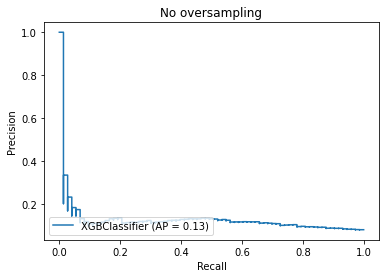

In [34]:
clf.fit(X_train, y_train)

disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title("No oversampling")

/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Text(0.5, 1.0, '1:1 SMOTE')

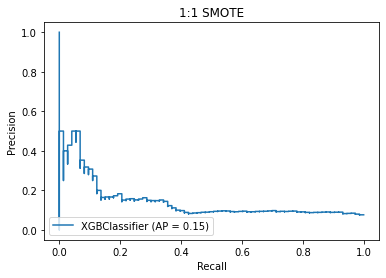

In [35]:
clf.fit(xs_smote[-1],ys_smote[-1])

disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title("1:1 SMOTE")

/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Text(0.5, 1.0, '1:1 synthsonic')

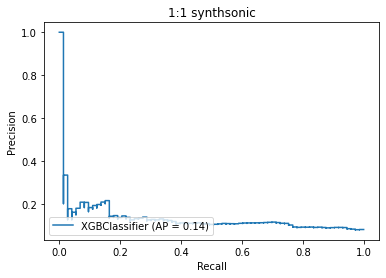

In [36]:
clf.fit(xs_synth[-1],ys_synth[-1])

disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title("1:1 synthsonic")

Text(0.5, 1.0, 'double sampling')

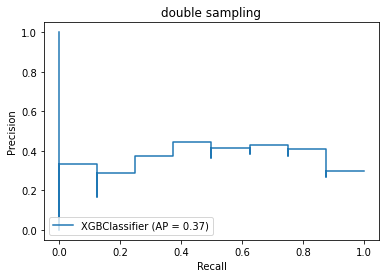

In [61]:
disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title("double sampling")

# Quick test - oversampling majority

In [54]:
ov = sv.SMOTE(proportion = 4, random_state=random_state)
X_train, y_train = ov.sample(X_train,y_train)

2021-06-11 15:59:53,083:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 15:59:53,083:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 15:59:53,083:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


In [55]:
ov = sv.SMOTE(proportion = 1, random_state=random_state)
X_g, y_g = ov.sample(X_train,y_train)

2021-06-11 16:00:10,757:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 16:00:10,757:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-11 16:00:10,757:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


In [56]:
X_g.shape

(1230, 7)

In [57]:
clf.fit(X_g,y_g)


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=5,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [58]:
qres = test_metrics(X_g,X_test,y_g,y_test, clf, "XGBoost: double oversample")

In [60]:
prediction = clf.predict(X_test)

confusion_matrix(y_test,prediction)

array([[119,   8],
       [  2,   6]])